## **FastAIClimbingStyleClassification**

# **Setup**

First we connect our Google Drive to write and read data to/from. When the command is executed, we are asked to provide the key for the Google Drive user account that we are going to be using.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The below commands ensure that any edits to libraries we make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Let's import FastAI libraries.

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

Let's setup the input and output folder variables and see that we have our drive and data available.

In [5]:
inputPath = Path('./drive/MyDrive/ML Projects/FastAIClimbingStyleClassification/input') # The folder where you place your datasets for training. "Path" comes from the FastAI library
inputPath.ls()

[PosixPath('drive/MyDrive/ML Projects/FastAIClimbingStyleClassification/input/test'),
 PosixPath('drive/MyDrive/ML Projects/FastAIClimbingStyleClassification/input/train'),
 PosixPath('drive/MyDrive/ML Projects/FastAIClimbingStyleClassification/input/valid')]

In [6]:
outputPath = Path('./drive/MyDrive/ML Projects/FastAIClimbingStyleClassification/output') # The folder where outputs will go
outputPath.ls()

[PosixPath('drive/MyDrive/ML Projects/FastAIClimbingStyleClassification/output/models'),
 PosixPath('drive/MyDrive/ML Projects/FastAIClimbingStyleClassification/output/resnet34_fastai_climbing_classifier_20_percent_error.pkl')]

Let's take a look at a few images that we have in our datasets.

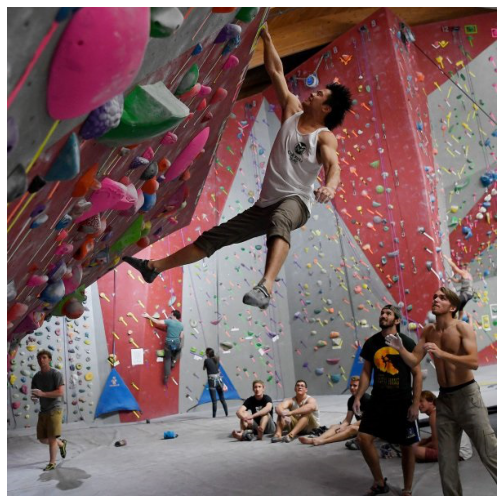

In [12]:
ImageList.from_folder(inputPath.joinpath('test'))[0].show(figsize=(9,9))

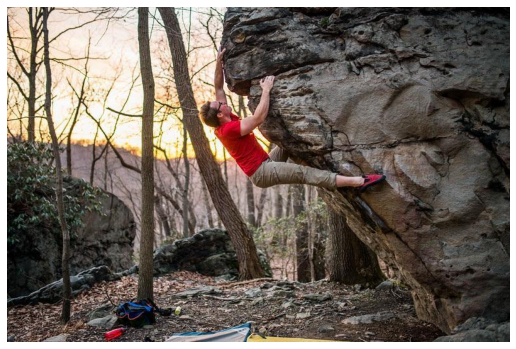

In [13]:
ImageList.from_folder(inputPath.joinpath('train/outdoor_bouldering'))[0].show(figsize=(9,9))

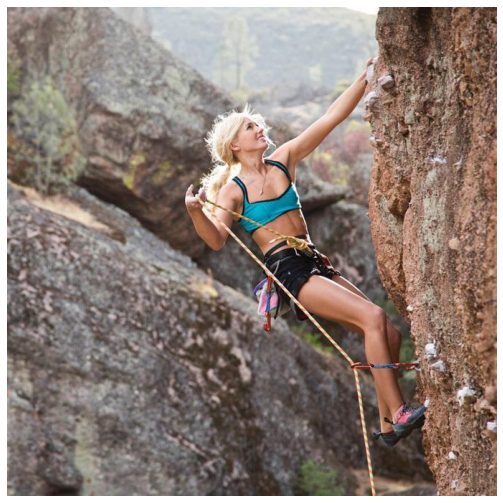

In [14]:
ImageList.from_folder(inputPath.joinpath('valid/outdoor_sport_climbing'))[2].show(figsize=(9,9))

Setup the environment to not show warnings - this has to do with the fact that FastAI is not properly updated (as of November 23, 2020) to work with the latest Pytorch library, so that warnings are being produced when we try to load or display image datasets.

In [15]:
import warnings
warnings.filterwarnings('ignore')

Set up the batch size variable for model training process.

In [16]:
batchSize = 16 # Make this smaller, if you don't have enough processing power
imgSize = 192 # Also possible to make this smaller, if you don't have enough processing power 
tfms = get_transforms()

Get the image data from the folders for training.

In [ ]:
data = ImageDataBunch.from_folder(path=inputPath, ds_tfms=tfms, size=imgSize, bs=batchSize).normalize(imagenet_stats)

Let's see what we've got for our labels.

In [ ]:
print(data.classes)

['indoor_bouldering', 'indoor_sport_climbing', 'outdoor_bouldering', 'outdoor_sport_climbing', 'outdoor_trad_climbing']


Training set has around 70 images for the following labels: 'indoor_bouldering', 'indoor_sport_climbing', 'outdoor_bouldering', 'outdoor_sport_climbing'. It has around 40 images for the 'outdoor_trad_climbing' label. For the validation sets we have 25 images for the 'indoor_bouldering', 'indoor_sport_climbing', 'outdoor_bouldering', 'outdoor_sport_climbing' labels and 10 images for the 'outdoor_trad_climbing' label. This discrepancy is bacause it is harder to find good quality pictures of that climbing style on the Internet :)

Let's examine what we've got in our training set.

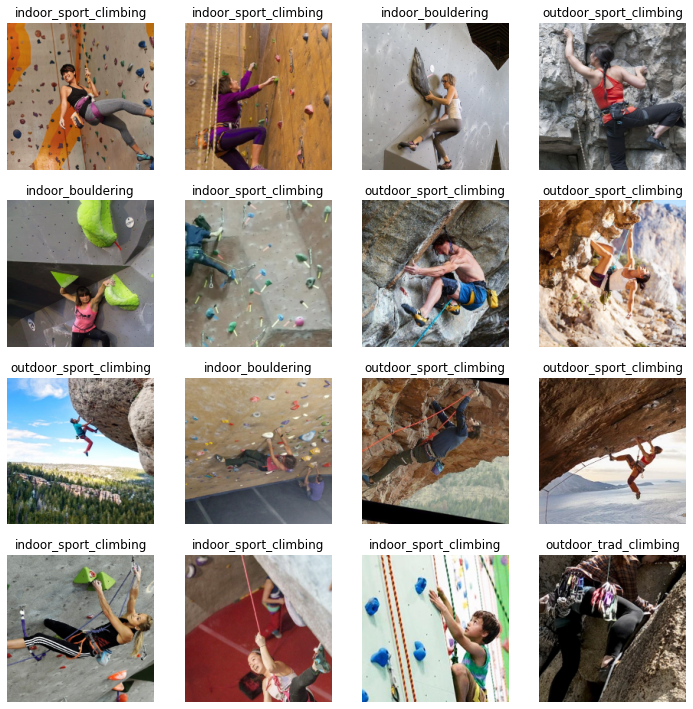

In [ ]:
data.show_batch(ds_type=DatasetType.Train, rows=4, figsize=(10,10))

Let's examine what we've got in our validation set.

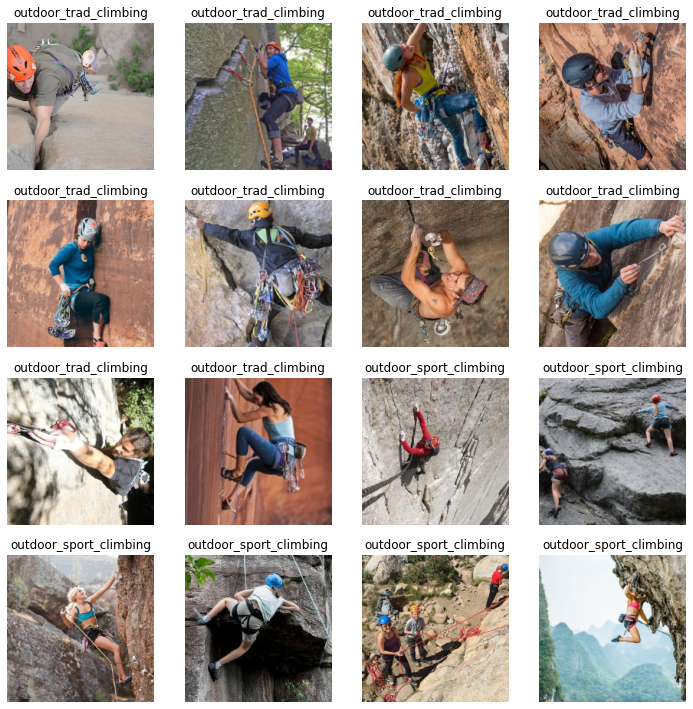

In [ ]:
data.show_batch(ds_type=DatasetType.Valid, rows=4, figsize=(10,10))

# **Training**

Setup the learner based on the RESNET34 architecture and the data that we 
provide. NOTE: this command will download already generally "pre-trained" model, so that it is going to be faster and easier for us to train it further for our specific need to classify climbing styles.

In [ ]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Setup the learner output path to the one that we going to be using for all output that it produces.

In [ ]:
learner.path = outputPath

Now let's train our model a little bit and see what we've got.

In [ ]:
learner.fit_one_cycle(4)

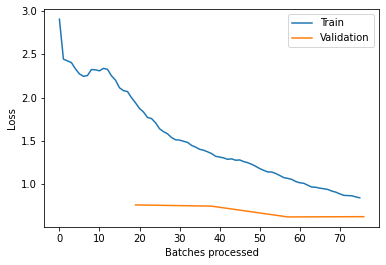

In [ ]:
learner.recorder.plot_losses()

In the above we've trained our model for 4 cycles and eventually we were able to get to about 80% accuracy (error rate around 20%), which is quite good considering that we haven't trained the model as much and also the amount of training data we've got. We can see that both training loss and validation loss are trending down, and training loss is slightly higher than validation loss, which is a good indication that our model is getting better at recognizing and generalizing without overfitting. Since both metrics are trending down, we should be able to train the model a little bit more and try getting a better accuracy. To do that we can try unfreezing the model, analyze learning rate parameter and then train the whole neural net using specific learning rate interval. Let's see what happens. P.S. Before we proceed let's save the model that we have for now.

In [ ]:
learner.save('climbing-classifier-stage-1-80-percent-accuracy') # Save the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


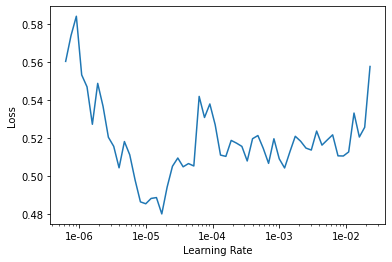

In [ ]:
learner.lr_find() # Analyze learning rate
learner.recorder.plot()

We can see that our learning rate and loss relation is trending down at first and then trending up after. Let's try to train our model two more cycles with the specific learning rate range of about 0.8e-5 to 0.2e-4 where loss is the lowest and see what we get.

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(0.8e-5,0.2e-4))

We can see now that the training loss is quite low and started to go up, while validation loss is already slightly higher than the training loss. It seems that at this point 80% accuracy is as good as we can get. Let's save this model as our final result.

In [ ]:
learner.save('climbing-classifier-stage-2-80-percent-accuracy-unfreezed') # Save the model

Also let's export this model so that it is ready to be used in production. The size of the exported "pkl" file is going to be much smaller than the saved model file.

In [ ]:
learner.export(file='resnet34_fastai_climbing_classifier_20_percent_error.pkl')

# **Results**

Let's analyze in more detail how our trained model works.

In [ ]:
interpretation = ClassificationInterpretation.from_learner(learner) # First, we get the classification interpretation from our model

In the image below we see which images the model confused the most while training. We're going to also examine the heatmaps for the predictions.

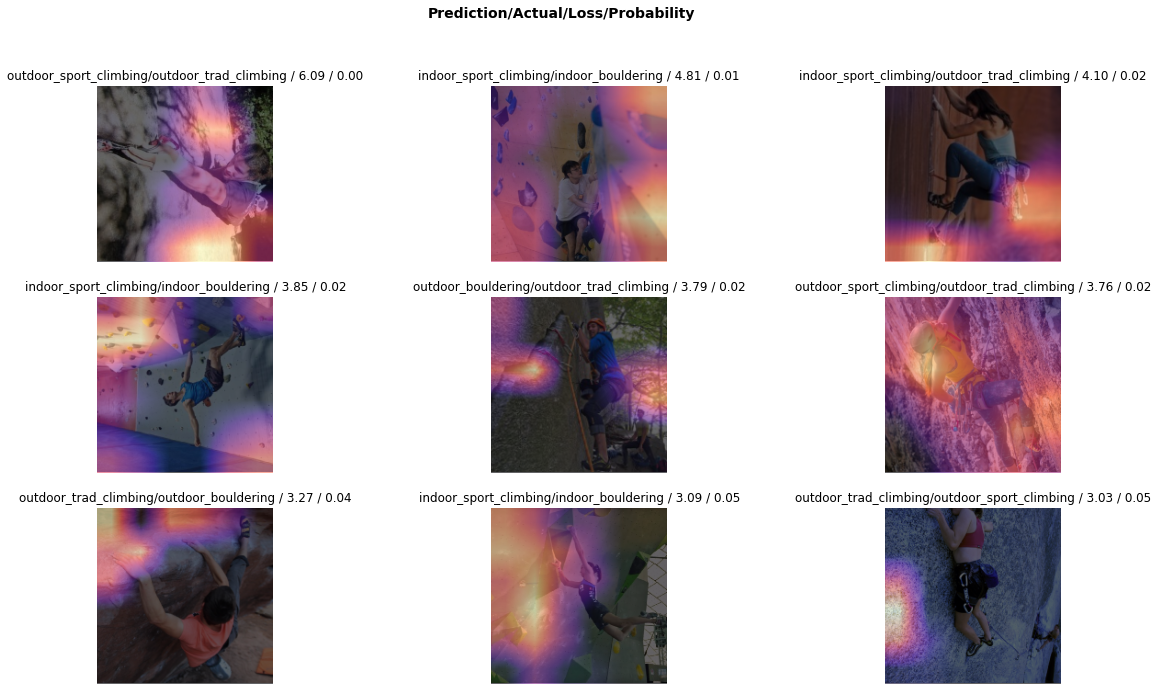

In [ ]:
interpretation.plot_top_losses(9, figsize=(20,11), heatmap=True)

In the above picture we can make an interesting observation actually. Based on the heatmaps displayed it looks like the model has learned to make the predictions based on the environment properties of the image and not really the subject (humans). This probably is related to the fact that human representation in the dataset is very diverse - the clothes, the positions and moves these people are doing are quite different in each picture. This actually creates an interesting question whether the model would change if we had a bigger training dataset, or would more data accentuate the importance and weight of the environment even more in making the predictions. 

So based on the previous paragraph and the output above that we see it is not a surprise to see that, for example, outdoor trad climbing got confused with the indoor sport climbing, or outdoor trad climbing got confused with the outdoor bouldering. None of the characteristics that would define certain style of climbing (like certain gear or body position, etc.) contributed the most to the decision being made.

It is actually a very interesting insight on what is happening here, and starting this project I definitely did not expect to see the results like this!

Let's see what we've got in the confusion matrix and try to analyze what we see having in mind the above observations about environment being the leading factor in classification.

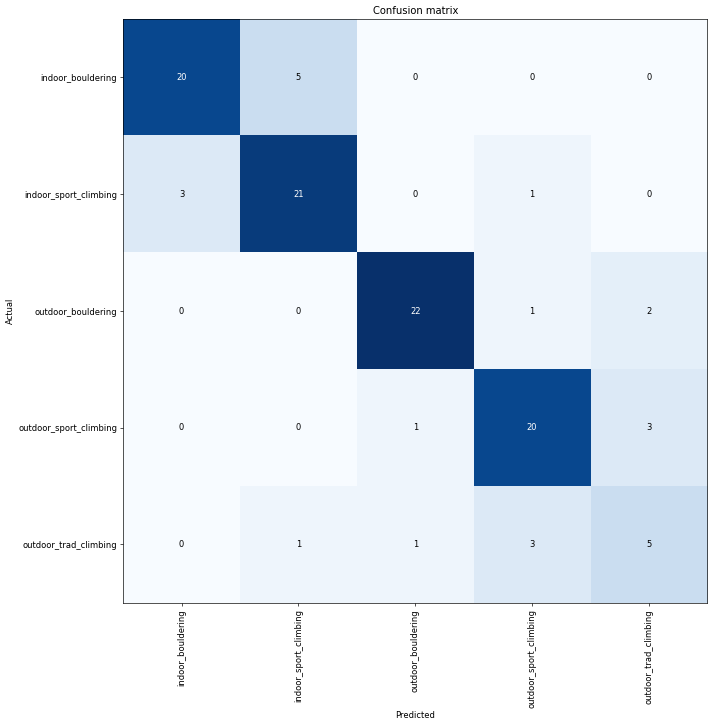

In [ ]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

As we can see in the above matrix, the model is mostly having difficulties differentiating between specific styles within two big subgroups of indoor and outdoor activities, which is expected since we know that the environments of indoor and outdoor differ greatly, having a lot more diverse colours present in the indoor setting. Knowing that the environment is the thing that adds most of the weight to the final decision, it is still quite interesting to see that the model does quite well in telling apart properly different styles of climbing within outdoor and indoor categories.

As a last step, let's try to actually pretend we are in production and test our model on the images it hasn't seen before, and see what we get.

In [ ]:
testPath = Path('./drive/MyDrive/ML Projects/FastAIClimbingStyleClassification/input/test') # Set the path where we have test data
testData = ImageList.from_folder(testPath) # Read the images into the list 
productionLearner = load_learner(path=outputPath, file='resnet34_fastai_climbing_classifier_20_percent_error.pkl', test=testData) # Load the learner from our production ready exported model file and provide test data to it

In [ ]:
predictions, predictedClasses = productionLearner.get_preds(ds_type=DatasetType.Test) # This will result in providing prediction tensors for every class for each image

In [ ]:
predictions

tensor([[6.4604e-02, 9.3534e-01, 1.8537e-07, 3.6070e-06, 5.4984e-05],
        [9.6253e-01, 3.4200e-02, 3.2302e-03, 1.2106e-07, 3.7778e-05],
        [4.1486e-02, 9.4321e-01, 3.6586e-04, 1.4604e-02, 3.3272e-04],
        [2.1905e-02, 9.7808e-01, 6.1749e-07, 4.3184e-06, 1.1730e-05],
        [8.8292e-01, 1.1470e-01, 1.9434e-06, 3.4998e-04, 2.0308e-03],
        [2.8822e-02, 9.9716e-04, 8.7811e-01, 1.1056e-02, 8.1016e-02],
        [3.1518e-03, 1.7791e-03, 8.5996e-01, 1.6507e-02, 1.1860e-01],
        [5.5600e-06, 2.2172e-03, 3.7476e-05, 9.8707e-01, 1.0674e-02],
        [2.7239e-06, 2.8130e-07, 2.6186e-02, 7.9518e-01, 1.7863e-01],
        [2.0163e-03, 1.2355e-03, 5.0662e-05, 9.7814e-01, 1.8561e-02],
        [2.7569e-04, 9.0536e-04, 2.7857e-03, 3.3769e-01, 6.5834e-01],
        [3.6148e-07, 2.4097e-03, 1.4596e-01, 7.9354e-01, 5.8094e-02]])

From the code above we've got predictions for every class for all images (12 rows for 12 images in the test set, 5 predictions for each of the five classes for each image). However, because the test set is unlabelled, we still need to manually infer the predicted class for each image ourselves. Otherwise the **classes** tensor has all 0s.

In [ ]:
predictedClasses = torch.argmax(predictions, dim=1) # Get resulting prediction class for each image
predictedClasses

tensor([1, 0, 1, 1, 0, 2, 2, 3, 3, 3, 4, 3])

Those numbers would correspond to the original classes that we had.

In [ ]:
data.classes # Original classes

['indoor_bouldering',
 'indoor_sport_climbing',
 'outdoor_bouldering',
 'outdoor_sport_climbing',
 'outdoor_trad_climbing']

In a similar way we could also be doing predictions for each single image by using the **productionLearner.predict** function.

In [ ]:
correctPredictions = 0

# Wasn't sure if there is a better way to get both file names and the actual image data, so opted out to go with index iteration
for idx in range(testData.items.size):
  image = testData[idx]
  _, pred_idx, outputs = productionLearner.predict(item=image)
  actualClassName = '_'.join(str(testData.items[idx]).split('/')[-1].split('_')[:-1]) # Get the actual class from the file name
  predictedClassName = data.classes[pred_idx]
  image.show(figsize=(5,5), title='Actual: ' + actualClassName + ' / Predicted: ' + predictedClassName + '\nPredicted class probabilities: ' + str(outputs))

  if (actualClassName == predictedClassName):
    correctPredictions = correctPredictions + 1

Output hidden; open in https://colab.research.google.com to view.

In [93]:
correctPredictions / testData.items.size * 100

66.66666666666666

For the test set of 12 images we've got only 66.66% of images classified correctly in this case.


# Conclusion

We've used realively small amount of data to train image classification ML model to recognize five different types of climbing styles. In the process of training and analysis of the model we were able to make an interesting observation that the model actually learned to differentiate between different classes based on the environment of each picture and not the climbers themselves. This actually makes sense, because the environments is what stays relatively the same between different images within one class, while climbers are very different in every image. To address that, one proposed approach I can think of is to actually eliminate the background from the equation either by switching it to black and white color or make everything except the climbers of completely the same color. On top of that having more data in training and validation datasets could potentially help as well.
All things considered (model training time, amount of training and test data, training accuracy and test accuracy), I think the final result of 66% accuracy is not bad at all, and I am quite happy with what I was able to learn from the process of working on this assignment.